In [1]:
%cd ..
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from melp import Detector
import melp
import math
import random

from melp.clustering.misc import*
import melp.clustering as clump
import melp.clustering.time_cluster as tclump
#from melp import TileAnalyzer
import melp.clustering.spatial_cluster as sclump
import melp.clustering.plots as clump_plt
import melp.clustering.three_frame_cluster as clump_3

plt.rcParams.update({'font.size': 16})

/home/erik/GitHub/melp
Welcome to JupyROOT 6.24/06


In [2]:
filename_trirec = "./testdata/trirec/trirec1.root"
filename_sorted = "./testdata/sorted/sorted1.root"
filename_sorted_big = "/home/erik/GitLab_KIP/melp/root_files/big_run_data/sorted1.root"
#filename_sorted_big = "./testdata/sorted/sorted1_big.root"
#fix
filename_sorted_big = "./testdata/sorted/sorted1_fix.root"

file = ROOT.TFile(filename_sorted)
ttree_mu3e = file.Get("mu3e")
ttree_mu3e_mc = file.Get("mu3e_mchits")
ttree_sensor = file.Get("alignment/sensors")
ttree_tiles = file.Get("alignment/tiles")

file_rec = ROOT.TFile(filename_trirec)
ttree_trirec = file_rec.Get("frames")
ttree_trirec_mc = file_rec.Get("frames_mc")
ttree_mu3e_segs = file_rec.Get("segs")

file_big = ROOT.TFile(filename_sorted_big)
ttree_mu3e_big = file_big.Get("mu3e")
ttree_mu3e_mc_big = file_big.Get("mu3e_mchits")
ttree_sensor_big = file_big.Get("alignment/sensors")
ttree_tiles_big = file_big.Get("alignment/tiles")

In [3]:
mu3e_detector = Detector.initFromROOT(filename_sorted)

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [4]:
melp.select(mu3e_detector)
print(mu3e_detector)

Detector(TileDetector=Loaded Tiles: 5824, SensorModules=<melp.src.sensor.SensorModule object at 0x7fdd4ce87a00>))


In [5]:
melp.addTileHits("./testdata/sorted/sorted1.root", truth=False, traj=False)
mu3e_detector.info()

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  [1]
  - Loaded Runs (Pixel):  []
------------------------------


In [6]:
#select frame to analyze
frame_used = 343 #29 #182
ttree_mu3e.GetEntry(frame_used)
ttree_mu3e_big.GetEntry(frame_used)

#build masks (and deconstruct them into arrays)
#masks = sclump.build_mask_detector_class(filename_sorted, frame_used, mu3e_detector, mask_type = "big")
masks, __ = clump.masks.build_mask_around_cluster_master(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, mask_type = "big", rec_type = None)

keys = []
values = []
for key in masks.keys():
    keys.append(key)
    values.append(masks[key])
    
#mu3e_detector.TileDetector.tile[keys[0]].id
#mu3e_detector.TileDetector.tile[keys[0]].hits
#print(values[0])


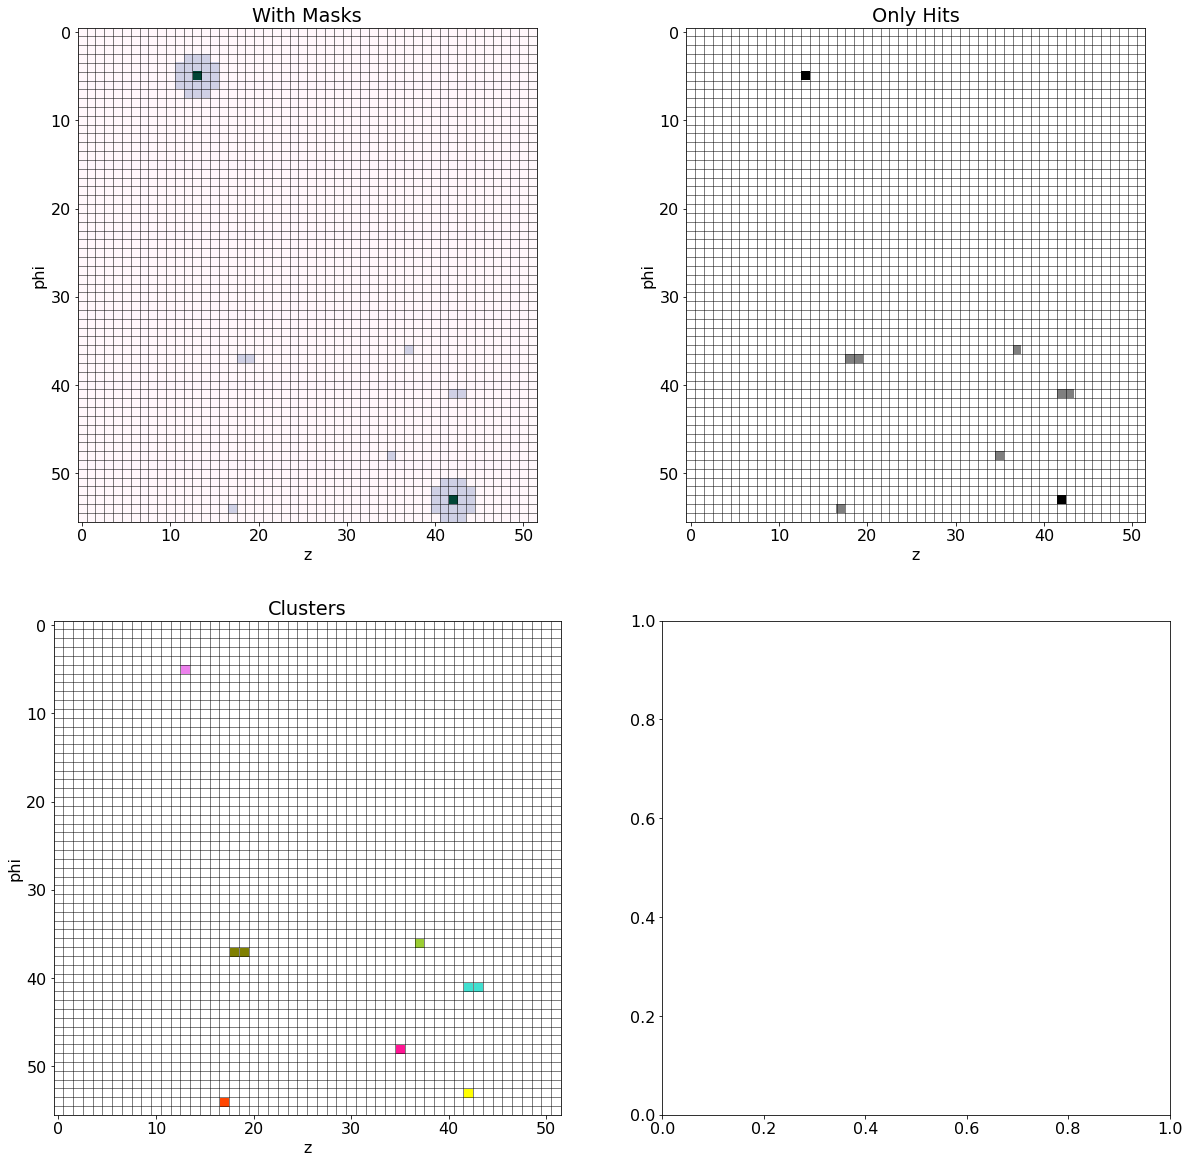

In [7]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    y = tile.row()
                    x = tile.column()
                    grid[x][y] += 1

#add masks
if all_hits == True:
    for i in range(len(values)):
        for mask_tile in values[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile]
            if mask_tile < 300000:
                y = tile.row()
                x = tile.column()
                grid[x][y] += 1

        #add centre a second and third time      
        if keys[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys[i]]
            y = tile.row()
            x = tile.column()
            grid[x][y] += 2
                     
if all_hits == False:
    for mask_tile in values[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            y = tile.row()
            x = tile.column()
            grid[x][y] += 1

    #add centre a second and third time      
    if keys[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys[single_hit]]
        y = tile.row()
        x = tile.column()
        grid[x][y] += 2
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                y = tile.row()
                x = tile.column()
                ref_grid[x][y] += 1
                
#plot primary hits into reference plot(truth)
cluster_master, cluster_master_primary = get_cluster_master_truth_frame(ttree_mu3e, ttree_mu3e_mc, frame_used)  
    
for i in range(len(cluster_master)):
    master = mu3e_detector.TileDetector.tile[cluster_master[i]]
    if master.id < 300000:
        y = master.row()
        x = master.column()
        ref_grid[x][y] += 1
                
                
heatplot = ax[0,1].imshow(ref_grid.T, cmap='binary')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")

#plot clusters
cluster_grid = np.zeros((52,56))
#clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector,frame_used, mask_type = "big", rec_type = "pixelpixel")
clusters = clump.three_dim_cluster.spatial_clustering_for_time_clusters(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters = []
whole_clusters = []
for i in range(len(clusters)):
    cluster_masters.append(clusters[i].master_id)
    whole_clusters.append(clusters[i].get_tile_ids())
    
for i in range(len(whole_clusters)):
    for j in whole_clusters[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

#scatter biggest cluster
"""
cluster_len = []
keys_biggest = []
for key in clusters.keys():
    cluster_len.append(len(clusters[key]))
    keys_biggest.append(key)
index_biggest_cluster = np.where(cluster_len == np.max(cluster_len))[0][0]
biggest_cluster = clusters[keys_biggest[index_biggest_cluster]]
for tile2 in biggest_cluster:
    tile_det = mu3e_detector.TileDetector.tile[tile2[0]] 
    if tile2[0] < 300000:
        y = tile_det.row()
        x = tile_det.column()
        ax[1,0].scatter(x, y, color = "b", marker = "o", s = 32)
"""
                
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
ax[1,0].set_xlim(-0.5,51.5)
ax[1,0].set_ylim(-0.5,55.5)
ax[1,0].invert_yaxis()

#cluster_numbers = []
#for x in range(np.shape(cluster_grid)[0]):
#    for y in range(np.shape(cluster_grid)[1]):
#        if cluster_grid[x][y] != 0:
#            cluster_numbers.append(cluster_grid[x][y])
#print(np.sort(cluster_numbers))                

In [8]:
clusters = clump.three_dim_cluster.spatial_clustering_for_time_clusters(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)
print(clusters)

[Cluster(id=201101, frame_id=343, master_id=201101, master_primary=257729, hits=[ClusterHit(tile_id=201045, frame_id=343, primary=257729, time=27013.047108817995), ClusterHit(tile_id=201101, frame_id=343, primary=257729, time=27012.8461082747)]), Cluster(id=202393, frame_id=343, master_id=202393, master_primary=284450, hits=[ClusterHit(tile_id=202449, frame_id=343, primary=-268479, time=27019.166292836875), ClusterHit(tile_id=202393, frame_id=343, primary=284450, time=27019.09327625967)]), Cluster(id=301336, frame_id=343, master_id=301336, master_primary=257263, hits=[ClusterHit(tile_id=301809, frame_id=343, primary=284693, time=27047.518734376285), ClusterHit(tile_id=301863, frame_id=343, primary=284693, time=27047.58040666058), ClusterHit(tile_id=302205, frame_id=343, primary=284697, time=27047.815696991445), ClusterHit(tile_id=301336, frame_id=343, primary=257263, time=27047.15037980807)]), Cluster(id=300144, frame_id=343, master_id=300144, master_primary=236279, hits=[ClusterHit(ti

In [9]:
hit_counter = 0 
for cluster in clusters:
    hit_counter += cluster.__len__()
print(hit_counter)

22


In [10]:
time_clusters = clump.time_cluster.time_clustering_frame(ttree_mu3e, frame_used)
print(time_clusters)

[Cluster(id=201101, frame_id=343, master_id=201101, master_primary=257729, hits=[ClusterHit(tile_id=201045, frame_id=343, primary=257729, time=27013.047108817995), ClusterHit(tile_id=201101, frame_id=343, primary=257729, time=27012.8461082747)]), Cluster(id=202393, frame_id=343, master_id=202393, master_primary=284450, hits=[ClusterHit(tile_id=202449, frame_id=343, primary=-268479, time=27019.166292836875), ClusterHit(tile_id=202393, frame_id=343, primary=284450, time=27019.09327625967), ClusterHit(tile_id=202008, frame_id=343, primary=268479, time=27019.521825235843)]), Cluster(id=301336, frame_id=343, master_id=301336, master_primary=257263, hits=[ClusterHit(tile_id=301807, frame_id=343, primary=284693, time=27047.660325570752), ClusterHit(tile_id=301809, frame_id=343, primary=284693, time=27047.518734376285), ClusterHit(tile_id=301808, frame_id=343, primary=284693, time=27047.79115282363), ClusterHit(tile_id=301863, frame_id=343, primary=284693, time=27047.58040666058), ClusterHit(t

In [11]:
time_hit_counter = 0
for time_cluster in time_clusters:
    time_hit_counter += time_cluster.__len__()
print(time_hit_counter)

22


In [12]:
print(len(time_clusters))

9


## Efficiency plots

In [13]:
frac_corr_frame_primary, frac_corr_clusters_frame_primary, frac_uncorr_frame_primary, tot_corr_primary = clump_plt.compare_to_primary(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "timethenspatial")

Progress: 100 % of  1000  frameses
Number of analyzed frames:  1000 Number of correct counter fractions:  996
Total #hits in frames/#hits in clusters =  1.0
Correctly associated out of all hits:  49.75451125422432 %
Correctly associated out of all hits in clusters:  49.75451125422432 %
Incorrectly associated out of all hits:  50.245488745775674 %
Incorrectly associated out of all hits in clusters:  50.245488745775674 %


### Hits not included in any cluster

In [14]:
frac_not_in_cluster = clump_plt.get_hits_not_in_cluster(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "timethenspatial")

Progress: 100 % of  1000  frameses
Not associated hits out of all hits:  0.0 %


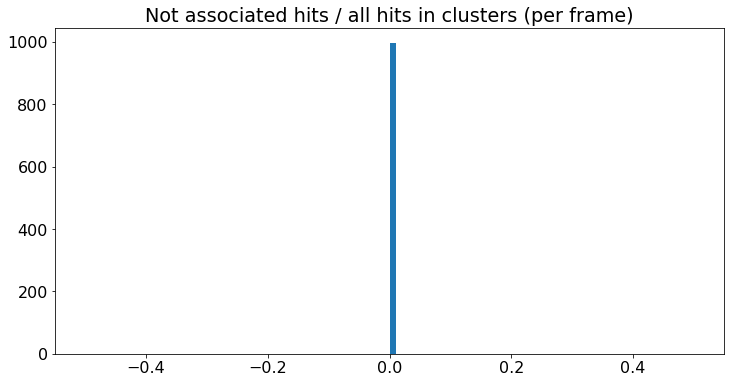

In [15]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_not_in_cluster, bins = 100)
plt.title("Not associated hits / all hits in clusters (per frame)")
plt.show()

### Hits associated to wrong cluster

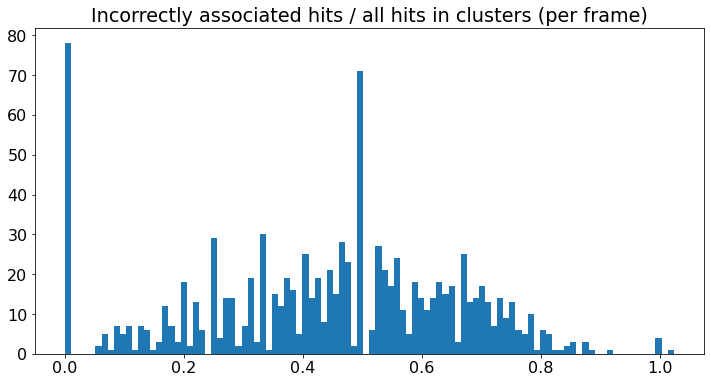

In [16]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_uncorr_frame_primary, bins = 100)
plt.title("Incorrectly associated hits / all hits in clusters (per frame)")
plt.show()

### Hits correctly associated

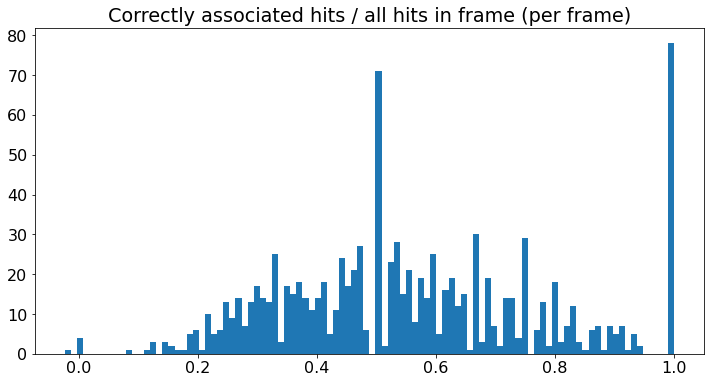

In [17]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in frame (per frame)")
plt.show()

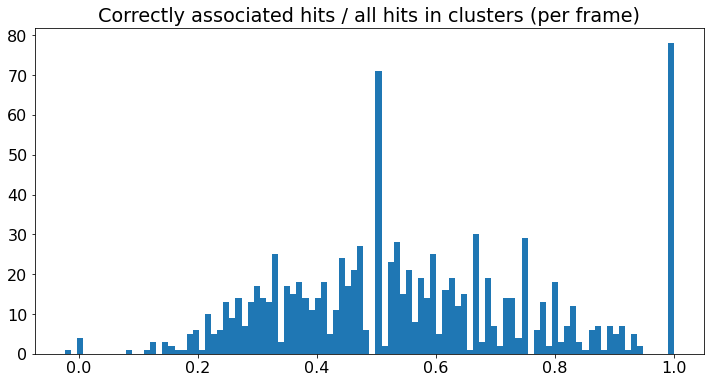

In [18]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in clusters (per frame)")
plt.show()

### Combined Histograms

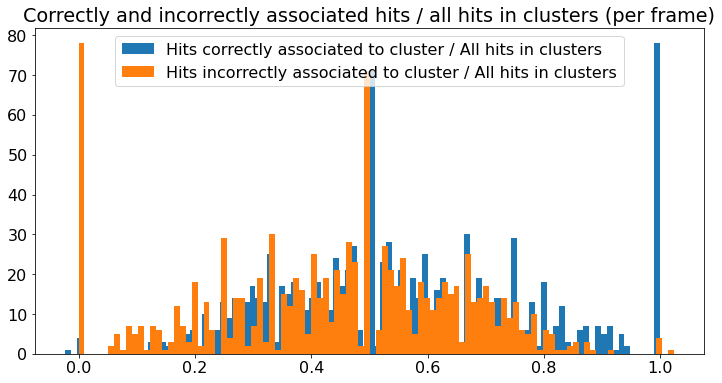

In [19]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100, label = "Hits correctly associated to cluster / All hits in clusters")
plt.hist(frac_uncorr_frame_primary, bins = 100, label = "Hits incorrectly associated to cluster / All hits in clusters")
plt.title("Correctly and incorrectly associated hits / all hits in clusters (per frame)")
plt.legend()
plt.show()

# Time then iterative spatial masks

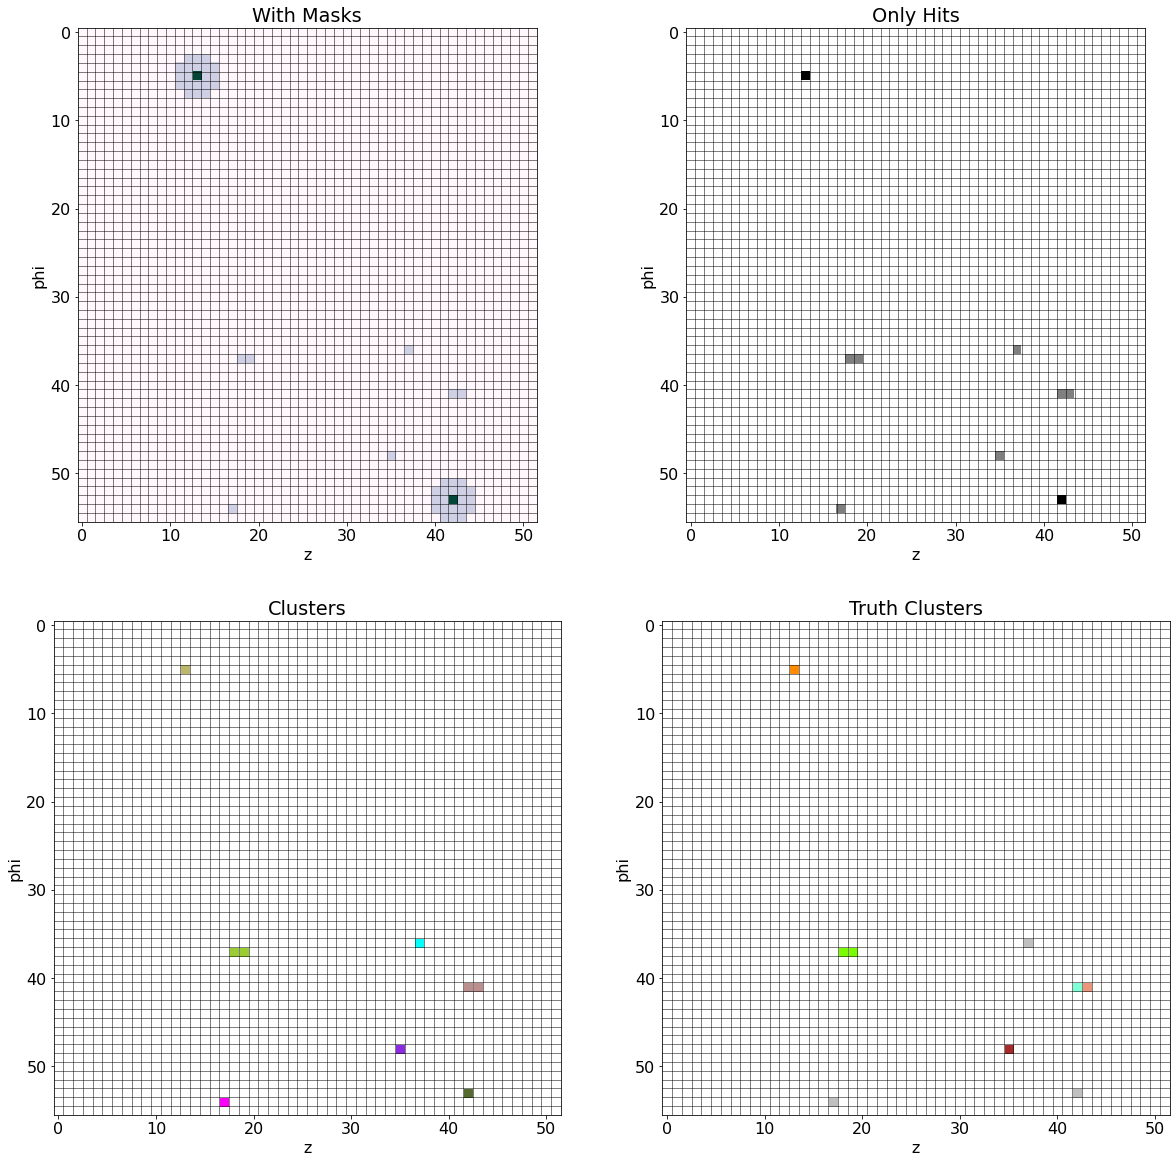

In [20]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    y = tile.row()
                    x = tile.column()
                    grid[x][y] += 1

#add masks
if all_hits == True:
    for i in range(len(values)):
        for mask_tile in values[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile]
            if mask_tile < 300000:
                y = tile.row()
                x = tile.column()
                grid[x][y] += 1

        #add centre a second and third time      
        if keys[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys[i]]
            y = tile.row()
            x = tile.column()
            grid[x][y] += 2
                     
if all_hits == False:
    for mask_tile in values[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            y = tile.row()
            x = tile.column()
            grid[x][y] += 1

    #add centre a second and third time      
    if keys[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys[single_hit]]
        y = tile.row()
        x = tile.column()
        grid[x][y] += 2
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                y = tile.row()
                x = tile.column()
                ref_grid[x][y] += 1
                
#plot primary hits into reference plot(truth)
cluster_master, cluster_master_primary = get_cluster_master_truth_frame(ttree_mu3e, ttree_mu3e_mc, frame_used)  
    
for i in range(len(cluster_master)):
    master = mu3e_detector.TileDetector.tile[cluster_master[i]]
    if master.id < 300000:
        y = master.row()
        x = master.column()
        ref_grid[x][y] += 1
                
                
heatplot = ax[0,1].imshow(ref_grid.T, cmap='binary')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")

#plot clusters
cluster_grid = np.zeros((52,56))
#clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector,frame_used, mask_type = "big", rec_type = "pixelpixel")
clusters = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters = []
whole_clusters = []
for i in range(len(clusters)):
    cluster_masters.append(clusters[i].master_id)
    whole_clusters.append(clusters[i].get_tile_ids())
    
for i in range(len(whole_clusters)):
    for j in whole_clusters[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

#scatter biggest cluster
"""
cluster_len = []
keys_biggest = []
for key in clusters.keys():
    cluster_len.append(len(clusters[key]))
    keys_biggest.append(key)
index_biggest_cluster = np.where(cluster_len == np.max(cluster_len))[0][0]
biggest_cluster = clusters[keys_biggest[index_biggest_cluster]]
for tile2 in biggest_cluster:
    tile_det = mu3e_detector.TileDetector.tile[tile2[0]] 
    if tile2[0] < 300000:
        y = tile_det.row()
        x = tile_det.column()
        ax[1,0].scatter(x, y, color = "b", marker = "o", s = 32)
"""
                
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
ax[1,0].set_xlim(-0.5,51.5)
ax[1,0].set_ylim(-0.5,55.5)
ax[1,0].invert_yaxis()

#plot reference truth clusters
cluster_grid = np.zeros((52,56))
#clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector,frame_used, mask_type = "big", rec_type = "pixelpixel")
clusters = clump.spatial_cluster.build_truth_cluster(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters = []
whole_clusters = []
for i in range(len(clusters)):
    cluster_masters.append(clusters[i].master_id)
    whole_clusters.append(clusters[i].get_tile_ids())
    
for i in range(len(whole_clusters)):
    for j in whole_clusters[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,1].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[1,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,1].set_title("Truth Clusters")
ax[1,1].set_xlabel("z")
ax[1,1].set_ylabel("phi")
ax[1,1].set_xlim(-0.5,51.5)
ax[1,1].set_ylim(-0.5,55.5)
ax[1,1].invert_yaxis()

### Plot clusters in next three frames

16055

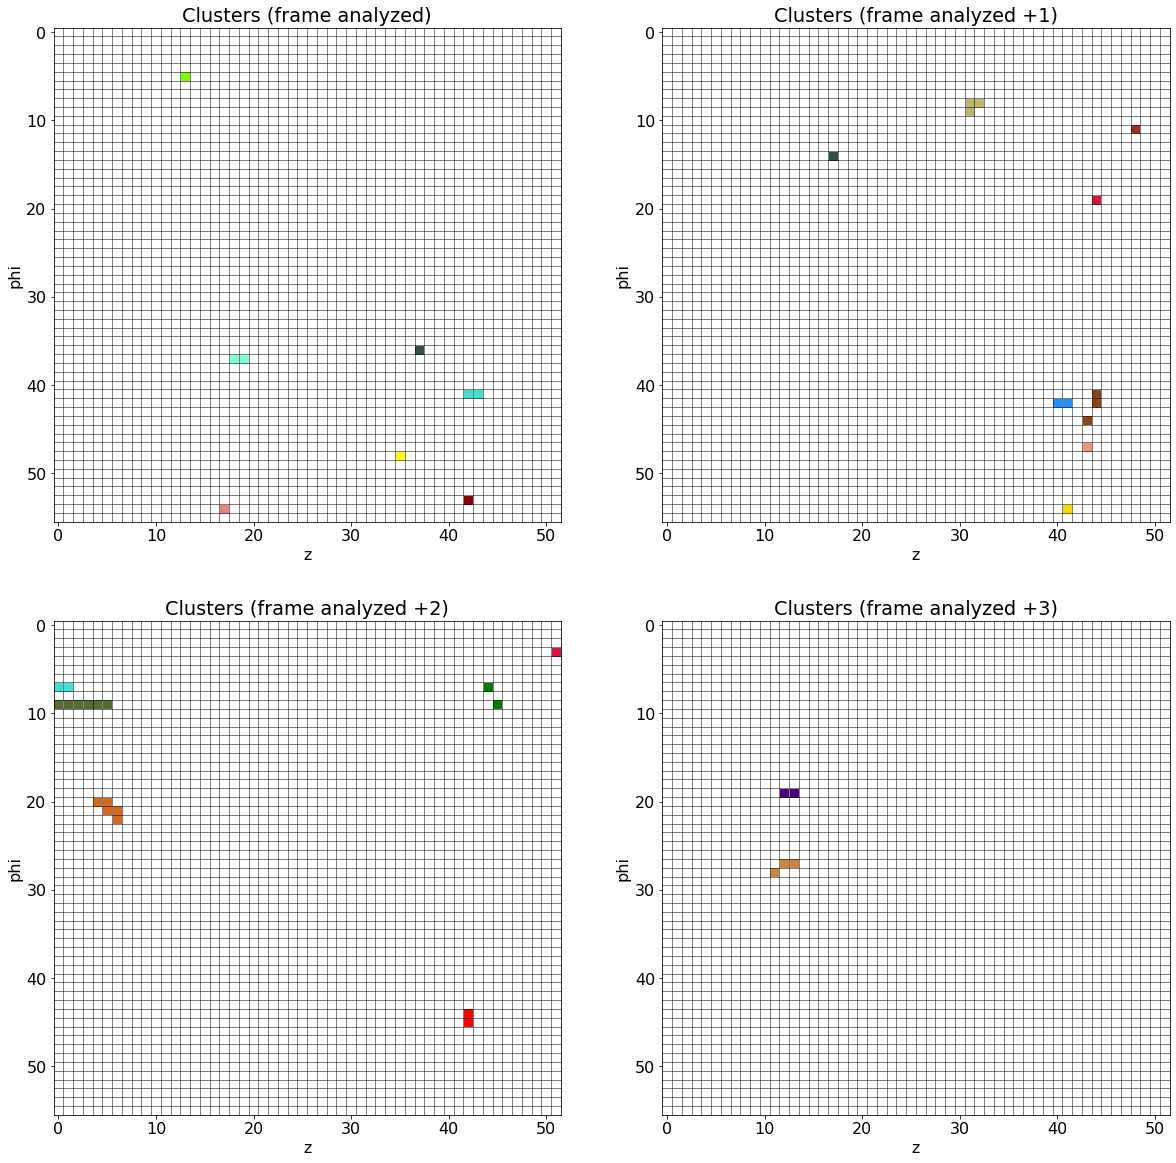

In [21]:
ttree_mu3e.GetEntry(frame_used)
ttree_mu3e_big.GetEntry(frame_used)

#plot clusters
fig, ax = plt.subplots(2,2, figsize=(20,20))

#plot clusters in frame_analyzed
clusters1 = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters_1 = []
whole_clusters_1 = []
for i in range(len(clusters1)):
    cluster_masters_1.append(clusters1[i].master_id)
    whole_clusters_1.append(clusters1[i].get_tile_ids())
###########################    
#print(whole_clusters_1[6])

#for tile2 in whole_clusters_1[6]:
#    tile_det = mu3e_detector.TileDetector.tile[tile2] 
#    if tile2 < 300000:
#        y = tile_det.row()
#        x = tile_det.column()
#        ax[0,0].scatter(x, y, color = "b", marker = "o", s = 32)
#############################
    
for i in range(len(whole_clusters_1)):
    for j in whole_clusters_1[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[0,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("Clusters (frame analyzed)")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")
ax[0,0].set_xlim(-0.5,51.5)
ax[0,0].set_ylim(-0.5,55.5)
ax[0,0].invert_yaxis()


#plot clusters in frame_analyzed +1
ttree_mu3e.GetEntry(frame_used+1)
ttree_mu3e_big.GetEntry(frame_used+1)
clusters2 = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame = frame_used+1, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters2 = []
whole_clusters2 = []
for i in range(len(clusters2)):
    cluster_masters2.append(clusters2[i].master_id)
    whole_clusters2.append(clusters2[i].get_tile_ids())
    
for i in range(len(whole_clusters2)):
    for j in whole_clusters2[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[0,1].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Clusters (frame analyzed +1)")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")
ax[0,1].set_xlim(-0.5,51.5)
ax[0,1].set_ylim(-0.5,55.5)
ax[0,1].invert_yaxis()


#plot clusters in frame_analyzed +2
ttree_mu3e.GetEntry(frame_used+2)
ttree_mu3e_big.GetEntry(frame_used+2)
clusters3 = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used+2, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters3 = []
whole_clusters3 = []
for i in range(len(clusters3)):
    cluster_masters3.append(clusters3[i].master_id)
    whole_clusters3.append(clusters3[i].get_tile_ids())
    
for i in range(len(whole_clusters3)):
    for j in whole_clusters3[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters (frame analyzed +2)")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
ax[1,0].set_xlim(-0.5,51.5)
ax[1,0].set_ylim(-0.5,55.5)
ax[1,0].invert_yaxis()


#plot clusters in frame_analyzed +3
ttree_mu3e.GetEntry(frame_used+3)
ttree_mu3e_big.GetEntry(frame_used+3)
clusters4 = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used+3, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters4 = []
whole_clusters4 = []
for i in range(len(clusters4)):
    cluster_masters4.append(clusters4[i].master_id)
    whole_clusters4.append(clusters4[i].get_tile_ids())
    
for i in range(len(whole_clusters4)):
    for j in whole_clusters4[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,1].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[1,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,1].set_title("Clusters (frame analyzed +3)")
ax[1,1].set_xlabel("z")
ax[1,1].set_ylabel("phi")
ax[1,1].set_xlim(-0.5,51.5)
ax[1,1].set_ylim(-0.5,55.5)
ax[1,1].invert_yaxis()

ttree_mu3e.GetEntry(frame_used)
ttree_mu3e_big.GetEntry(frame_used)

In [22]:
clusters = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)
hits_in_clusters = 0
for cluster in clusters:
    hits_in_clusters += cluster.__len__()
    
print("#hits in clusters in frame" ,clusters[0].frame_id, "=",hits_in_clusters, )

#hits in clusters in frame 343 = 22


In [23]:
print(len(clusters))

14


## Efficiency plots

In [24]:
frac_corr_frame_primary, frac_corr_clusters_frame_primary, frac_uncorr_frame_primary, tot_corr_primary = clump_plt.compare_to_primary(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "timetheniterativespatial")

Progress: 100 % of  1000  frameses
Number of analyzed frames:  1000 Number of correct counter fractions:  996
Total #hits in frames/#hits in clusters =  1.0
Correctly associated out of all hits:  76.31193011541158 %
Correctly associated out of all hits in clusters:  76.31193011541158 %
Incorrectly associated out of all hits:  23.688069884588405 %
Incorrectly associated out of all hits in clusters:  23.688069884588405 %


### Hits not included in any cluster

In [25]:
frac_not_in_cluster = clump_plt.get_hits_not_in_cluster(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "timetheniterativespatial")

Progress: 100 % of  1000  frameses
Not associated hits out of all hits:  0.0 %


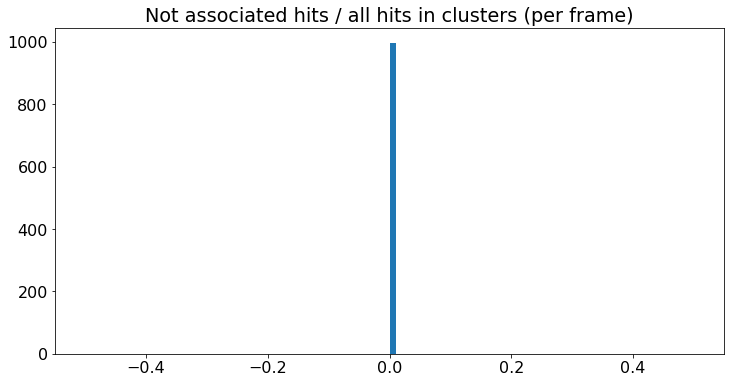

In [26]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_not_in_cluster, bins = 100)
plt.title("Not associated hits / all hits in clusters (per frame)")
plt.show()

### Hits associated to wrong cluster

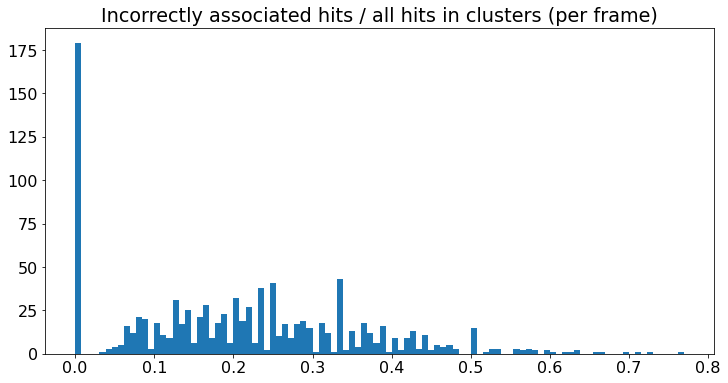

In [27]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_uncorr_frame_primary, bins = 100)
plt.title("Incorrectly associated hits / all hits in clusters (per frame)")
plt.show()

### Hits correctly associated

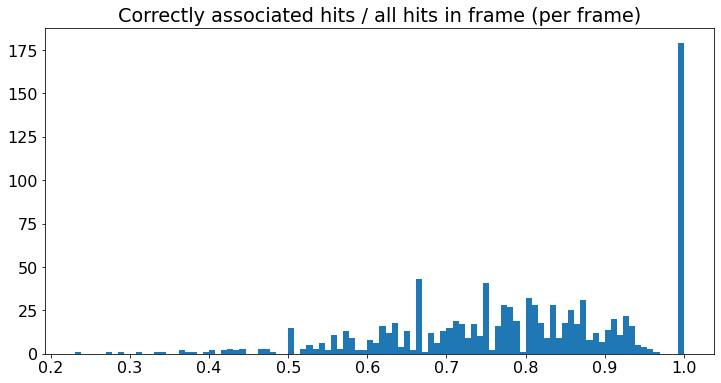

In [28]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in frame (per frame)")
plt.show()

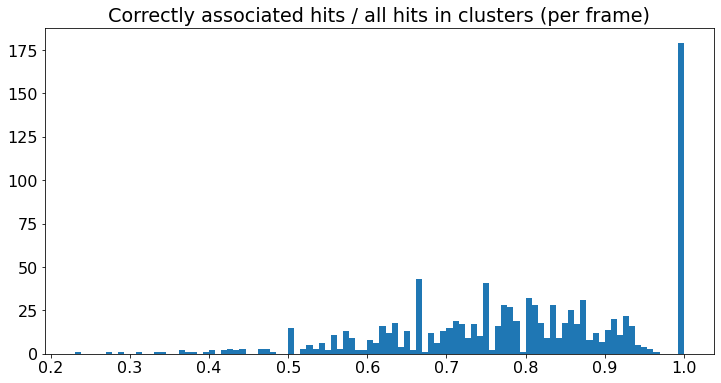

In [29]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in clusters (per frame)")
plt.show()

### Combined Histograms

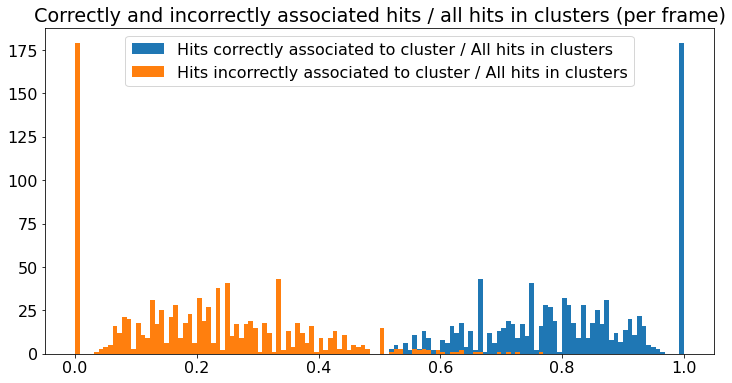

In [30]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100, label = "Hits correctly associated to cluster / All hits in clusters")
plt.hist(frac_uncorr_frame_primary, bins = 100, label = "Hits incorrectly associated to cluster / All hits in clusters")
plt.title("Correctly and incorrectly associated hits / all hits in clusters (per frame)")
plt.legend()
plt.show()